In [1]:
# Calcula la precipitacion diaria media para el periodo
# 1979 - 2020 en la Cuenca del Valle de México.

import pandas as pd
import numpy as np

import xarray as xr

import matplotlib.pyplot as plt

import matplotlib.dates as mdates

In [2]:
path_r = "../results/onset/"
path_cpc = path_r  + "CPC_Pre/cuenca_valle_mexico/"
fname_cpc = "cuenca_valle_mexico_precip.nc"
fname_grid = "grid_points.csv"

# Se leen los límites de la cuenca.
df_grid = pd.read_csv(path_r + fname_grid)
lon_i = 360 + df_grid.lon.min()
lon_f = 360 + df_grid.lon.max() + 0.5
lat_i = df_grid.lat.min()
lat_f = df_grid.lat.max() + 0.5

# Se carga la precipitación.
pre_xr = xr.load_dataset(path_cpc + fname_cpc)
# Se recorta la zona de estudio.
pre_xr = pre_xr.sel( dict( lon = np.arange(lon_i, lon_f, 0.5),
    lat = np.arange(lat_i, lat_f, 0.5) ) )

In [3]:
# Reordenamos las coordenadas.
df_grid.sort_values("lat", ascending = False, inplace = True)
df_grid.reset_index(drop = True, inplace = True)

df = pd.DataFrame()

# Agregamos una columna por cada coordenada.
for i in range( df_grid.shape[0] ):
    df[f"{df_grid.loc[i, 'lon']}, " +
        f"{df_grid.loc[i, 'lat']}"] = (
        pre_xr.sel( {
            "lon": 360 + df_grid.loc[i, 'lon'],
            "lat": df_grid.loc[i, 'lat']
        } ).to_dataframe()["precip"]
        )

# Media móvil.
df = df.iloc[-15:,:].append( df.append( df.iloc[0:15,:] ) )
df = df.rolling(15, center = True).mean()
df = df.iloc[15:-15,:]

In [4]:
# Crea un índice de onset de acuerdo con
# el umbral para n días seguidos de
# cumplimiento con el criterio.
umbral = 2
n = 3

df_ind = df.copy()

for c in df.columns:
    # Nombre de las columnas dummy.
    proc = [c]
    for i in range(0, n):
        proc.append(c +
            "_" + str(i)) 

    # Traslapa los últimos 3 días 
    # y da un valor de 1 a cada día 
    # que cumpla con el umbral.
    for i, p in enumerate(proc[1:]):
        df_ind[p] = df_ind[proc[0]].shift(i)
        df_ind[p].clip( upper = umbral,
            inplace = True )
        df_ind[p] = df_ind[p].where(
            df_ind[p] == umbral, 0)
        df_ind[p] = df_ind[p].where(
            df_ind[p] < umbral, 1)

    # El índice es uno si los tres
    # cumplen con el umbral.
    ind = "Index_" + c
    df_ind[ind] = ( df_ind[proc[1]] +
        df_ind[proc[2]] + df_ind[proc[3]] )
    df_ind[ind] = df_ind[ ind
        ].where(df_ind[ind] == 3, 0)
    df_ind[ind] = df_ind[ ind
        ].where(df_ind[ind] < 3, 1)
    df_ind.drop(proc[1:],
        axis = 1, inplace = True)

99.25, 20.25: 02 May - 27 October
98.75, 20.25: 29 March - 30 October
99.25, 19.75: 23 April - 28 October
98.75, 19.75: 05 April - 29 October
99.25, 19.25: 23 April - 29 October
98.75, 19.25: 14 April - 28 October


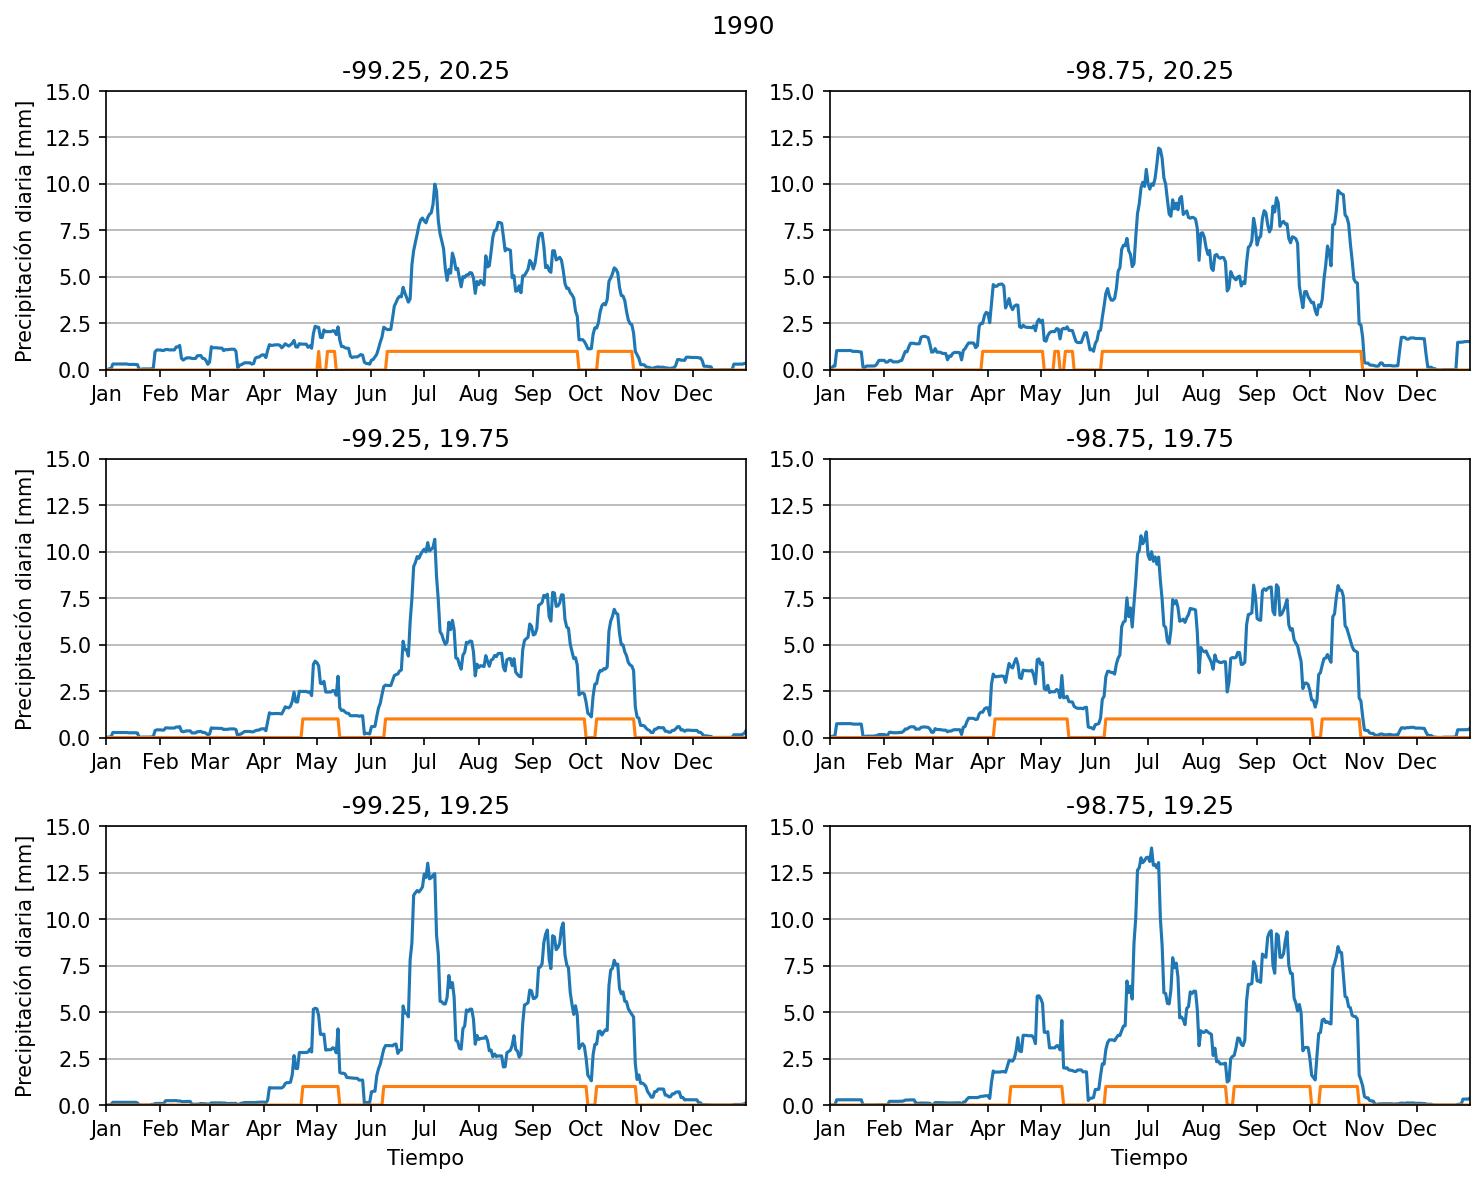

In [13]:
year = 1990

df_year = df_ind[ df_ind.index.year == year ]

# Fechas.
for i in df_year.columns[6:]:
    onset = df_year.loc[:, i].idxmax()
    withdrawal = df_year.loc[::-1, i].idxmax()

    print( i[7:]
        + f": {onset.day:02d}"
        + f" {onset.month_name()} - "
        + f"{withdrawal.day:02d}"
        + f" {withdrawal.month_name()}"
        )

# Graficamos.
fig, axes = plt.subplots(nrows = 3, ncols = 2)
fig.set_size_inches(10, 8)
fig.set_dpi(150)

for i, ax in enumerate(axes.flatten()):
    ax.plot(df_year.iloc[:, i])
    ax.plot(df_year.iloc[:, i + 6])
    ax.set_title(df_year.iloc[:, i].name)
    ax.grid(axis = "y")
    if i % 2 == 0:
        ax.set_ylabel("Precipitación diaria [mm]")
    if i in [4, 5]: 
        ax.set_xlabel("Tiempo")
    ax.set_ylim(0, 15)
    ax.set_xlim( pd.to_datetime(str(year) + "-01-01"),
        pd.to_datetime(str(year) + "-12-31") )
    # Formato de fecha.
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))

fig.suptitle(year)

# Separación adecuada entre gráficas.
fig.tight_layout()

fig.savefig(path_r + "pre_ind.png", bbox_inches = "tight")